In [1]:
import sys, os
insert_path = os.path.dirname(os.path.abspath(""))
sys.path.insert(0, insert_path)

In [107]:
from model.models.threes import ThreesModel
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from model.nba_api_helpers import get_player_shot_loc_data, get_league_shot_loc_data
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import GridSearchCV
from model.utils.plotting import draw_court

In [48]:
bootstrap_samples = 100_000
player_df = get_player_shot_loc_data("Jordan Poole", context_measure_simple='FG3A')
threes = player_df.loc[:, ['GAME_ID', 'LOC_X', 'LOC_Y', 'SHOT_MADE_FLAG', 'SHOT_ATTEMPTED_FLAG']]
threes = threes.dropna()

threes['SHOT_MADE_FLAG'] = threes['SHOT_MADE_FLAG'].astype(np.int64)

threes_train_xy = threes[['LOC_X', 'LOC_Y']].values.reshape(-1, 2)
fga_per_game_data = threes.groupby('GAME_ID')['SHOT_ATTEMPTED_FLAG'].count().values

#get league shot data

league_df = get_league_shot_loc_data(context_measure_simple='FG3A')
league_test_xy = league_df[['LOC_X', 'LOC_Y']].values.reshape(-1, 2)

param_grid = {
    "n_components": range(2, 15),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GMM(), param_grid=param_grid, scoring=lambda estimator, x: -estimator.bic(x)
)

grid_search.fit(threes_train_xy)

covariance_type = grid_search.best_params_['covariance_type']
n_components = grid_search.best_params_['n_components']
print(n_components)
model = GMM(n_components=n_components, covariance_type=covariance_type, random_state=0).fit(threes_train_xy)

model_labels_ = model.predict(threes_train_xy)

league_model_labels_ = model.predict(league_test_xy)
league_df['cluster'] = league_model_labels_

#filter for opponent after assigning clusters
opponent_df = league_df.loc[league_df['DEF'] == opponent]

#create a dataframe from the cluster data dictionary
cluster_df = pd.DataFrame({
    'shot_made': threes['SHOT_MADE_FLAG'],
    'cluster': model_labels_
})

#shooting percentage by cluster
fg_percent_by_cluster = pd.DataFrame(cluster_df.groupby('cluster')['shot_made'].value_counts(normalize=True)).rename({'shot_made': 'fg_percent'}, axis=1).reset_index()
fg_percent_by_cluster = fg_percent_by_cluster.loc[fg_percent_by_cluster['shot_made'] == 1].drop('shot_made', axis=1)['fg_percent']

#league fg% by cluster
league_fg_percent_by_cluster = pd.DataFrame(league_df.groupby('cluster')['SHOT_MADE_FLAG'].value_counts(normalize=True)).rename({'SHOT_MADE_FLAG': 'fg_percent'}, axis=1).reset_index()
league_fg_percent_by_cluster = league_fg_percent_by_cluster.loc[league_fg_percent_by_cluster['SHOT_MADE_FLAG'] == 1].drop('SHOT_MADE_FLAG', axis=1)['fg_percent']

#opponent def fg% by cluster
opponent_fg_percent_by_cluster = pd.DataFrame(opponent_df.groupby('cluster')['SHOT_MADE_FLAG'].value_counts(normalize=True)).rename({'SHOT_MADE_FLAG': 'fg_percent'}, axis=1).reset_index()
opponent_fg_percent_by_cluster = opponent_fg_percent_by_cluster.loc[opponent_fg_percent_by_cluster['SHOT_MADE_FLAG'] == 1].drop('SHOT_MADE_FLAG', axis=1)['fg_percent']

#opponent defensive ratings per cluster relative to league average
def_adjustment = opponent_fg_percent_by_cluster / league_fg_percent_by_cluster

#bootstrap resample from FGA data to find normal distribution fo estimated mean FGA per game
fga_per_game_est = [np.random.choice(fga_per_game_data, size=len(fga_per_game_data), replace=True).mean() for _ in range(bootstrap_samples)]
fga_per_game_est_mean = np.mean(fga_per_game_est)
fga_per_game_est_std = np.std(fga_per_game_est)

3


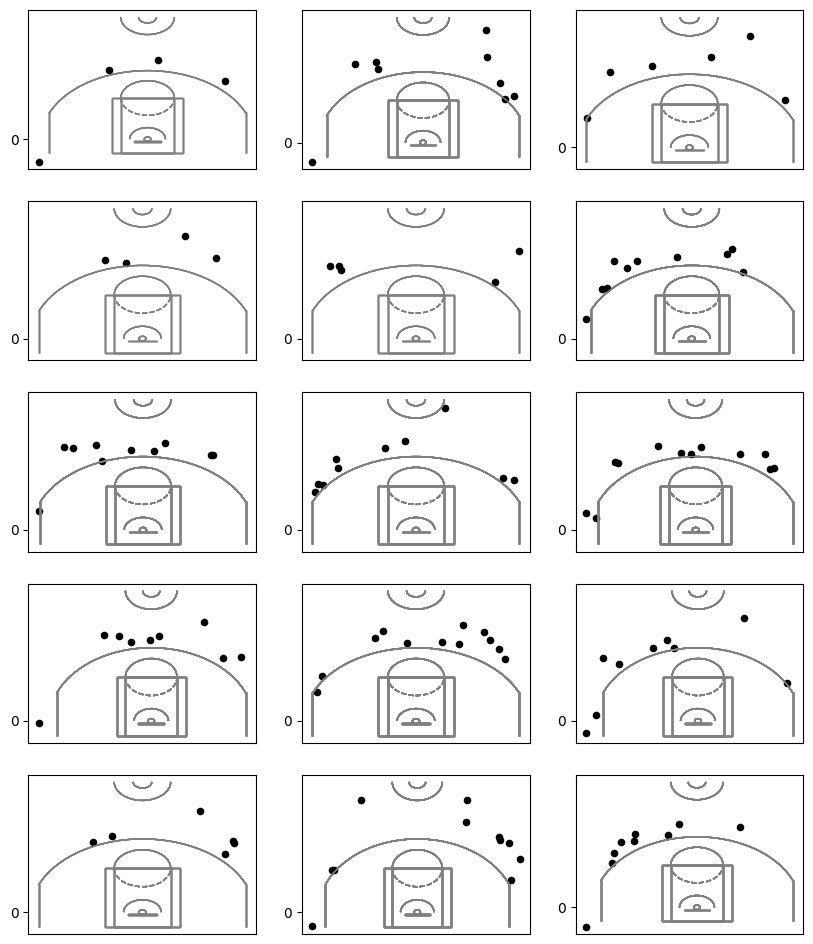

In [180]:
fig, axes = plt.subplots(5, 3, figsize=(10, 12))
for row in axes:
    for ax in row:
        #simulate FGA
        fga_i = np.random.poisson(np.random.normal(fga_per_game_est_mean, fga_per_game_est_std))
        sampled_shot_locs = np.array([])
        for fga in range(fga_i):
            selected_cluster = np.random.choice(np.arange(0, n_components), p=model.weights_)
            not_3_point_shot = True
            while not_3_point_shot:
                sampled_shot = np.random.multivariate_normal(
                    model.means_[selected_cluster], model.covariances_[selected_cluster]
                )
                three_point_shot = clf.predict([sampled_shot])[0]
                not_3_point_shot = not three_point_shot
                
            sampled_shot_locs = np.append(sampled_shot_locs, sampled_shot)
            ax.scatter(x=sampled_shot[0], y=sampled_shot[1], color='black', s=20)
            draw_court(ax=ax, lw=1, color="grey")
            ax.set_xticks([]); ax.set_yticks([0])

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split()

In [121]:
league_test_xy

array([[-232.,   49.],
       [ 116.,  241.],
       [ -82.,  281.],
       ...,
       [ 233.,    2.],
       [-183.,  195.],
       [-152.,  243.]])

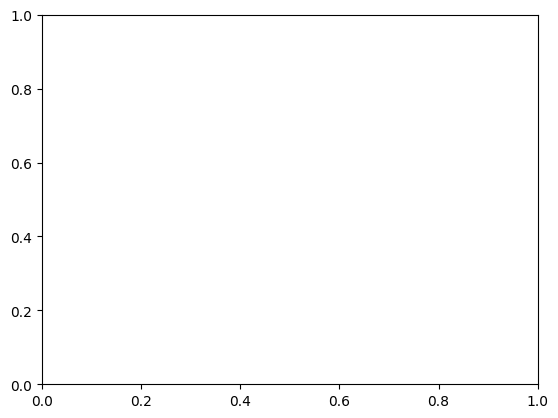

In [123]:
fig, ax = plt.subplots()

In [158]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from nba_api.stats.endpoints import shotchartdetail

In [127]:
league_shots = shotchartdetail.ShotChartDetail(
        player_id=0,
        team_id=0,
        season_type_all_star='Regular Season',
        context_measure_simple='FGA'
    )

In [129]:
league_shots_df = league_shots.get_data_frames()[0]
league_shots_df['three'] = league_shots_df['SHOT_ZONE_BASIC'].isin(['Left Corner 3', 'Above the Break 3', 'Right Corner 3','Backcourt']).astype(int)
X, y = league_shots_df[['LOC_X', 'LOC_Y']].values, league_shots_df['three'].values
league_shots_df.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0022200001,7,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,11,38,...,Left Side(L),8-16 ft.,12,-118,50,1,0,20221018,BOS,PHI
1,Shot Chart Detail,0022200001,11,203935,Marcus Smart,1610612738,Boston Celtics,1,11,15,...,Right Side(R),8-16 ft.,13,120,55,1,1,20221018,BOS,PHI
2,Shot Chart Detail,0022200001,12,202699,Tobias Harris,1610612755,Philadelphia 76ers,1,11,5,...,Center(C),8-16 ft.,14,50,135,1,0,20221018,BOS,PHI
3,Shot Chart Detail,0022200001,14,202699,Tobias Harris,1610612755,Philadelphia 76ers,1,11,3,...,Center(C),Less Than 8 ft.,0,0,0,1,1,20221018,BOS,PHI
4,Shot Chart Detail,0022200001,15,1628369,Jayson Tatum,1610612738,Boston Celtics,1,10,46,...,Left Side(L),24+ ft.,23,-232,49,1,1,20221018,BOS,PHI


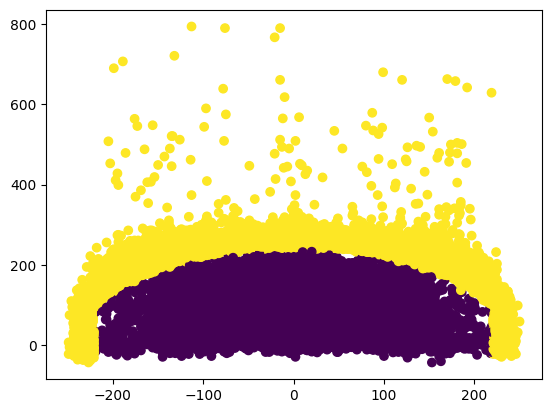

In [159]:
Classifier = RandomForestClassifier
clf = Classifier()
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred);

In [162]:
clf.__dict__

{'estimator': DecisionTreeClassifier(),
 'n_estimators': 100,
 'estimator_params': ('criterion',
  'max_depth',
  'min_samples_split',
  'min_samples_leaf',
  'min_weight_fraction_leaf',
  'max_features',
  'max_leaf_nodes',
  'min_impurity_decrease',
  'random_state',
  'ccp_alpha'),
 'base_estimator': 'deprecated',
 'bootstrap': True,
 'oob_score': False,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False,
 'class_weight': None,
 'max_samples': None,
 'criterion': 'gini',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'ccp_alpha': 0.0,
 'n_features_in_': 2,
 'n_outputs_': 1,
 'classes_': array([0, 1]),
 'n_classes_': 2,
 '_estimator': DecisionTreeClassifier(),
 'estimators_': [DecisionTreeClassifier(max_features='sqrt', random_state=773662004),
  DecisionTreeClassifier(max_features='sqrt', random_state=1904199769),
  Decisi

In [167]:
clf.predict([[120, 12]])

array([0])